In [1]:
import pandas as pd
import numpy as np
import pickle as pk
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import zlib

# manually specify the GPUs to use
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import math
import random
import MinkowskiEngine as ME
from torch.utils.data import Dataset, DataLoader
from glob import glob
from glob import iglob
import os.path as osp, h5py, tqdm
import utils
from Core import utils
from Core.trainers import Trainer


# System
import time
# Externals
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import tqdm, psutil
from scipy.special import softmax
from sklearn.metrics import classification_report, confusion_matrix, explained_variance_score

/usr/local/lib64/python3.6/site-packages/MinkowskiEngine-0.5.2-py3.6-linux-x86_64.egg/MinkowskiEngine/__init__.py:42: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  "It is recommended to set it below 24.",
/usr/local/lib64/python3.6/site-packages/MinkowskiEngine-0.5.2-py3.6-linux-x86_64.egg/MinkowskiEngine/__init__.py:224: UserWarning: The MinkowskiEngine was compiled with CPU_ONLY flag. If you want to compile with CUDA support, make sure `torch.cuda.is_available()` is True when you install MinkowskiEngine.
  "If you want to compile with CUDA support, make sure `torch.cuda.is_available()` is True when you install MinkowskiEngine.",


In [2]:
# from PDG to label
def pdg2tos(pdg):
    if pdg==13 or pdg==-13 or pdg==211 or pdg==-211:
        return 0 # track
    if pdg==2212 or pdg==321 or pdg==-321:
        return 0 # heavy track
    if pdg==11 or pdg==-11 or pdg==22:
        return 1 # shower
    return -1

In [ ]:
# Generate events

graph=0
voxel_size=0.05 # cm
#numGraphs = len(list(iglob('/eos/home-a/aabedabu/physics_gnn/physics_processed_data_collection/prod4/grid_40k/1GeV_?/mc_sce_dd/*/*.gz')))
#for graph_path in iglob('/eos/home-a/aabedabu/physics_gnn/physics_processed_data_collection/prod4/grid_40k/1GeV_?/mc_sce_dd/*/*.gz'):
numGraphs = len(list(iglob('../../data_grid_leigh/9*/*.gz')))
for graph_path in iglob('../../data_grid_leigh/9*/*.gz'):
    if graph % 100 == 0:
      print(str(graph+1) + " out of " + str(numGraphs))
    example = {}
    with open(graph_path[:-3]+'.info', 'rb') as info_file:
        lines = info_file.readlines()
        values = {'X':float(lines[0]),
                  'Y':float(lines[1]),
                  'Z':float(lines[2]),
                  'Energy':float(lines[3]),
                  'Interaction':int(lines[4]),
                  'PDG':int(lines[5]),
                  'NumberOfNodes':int(lines[6]),
                  'NumberOfFeatures':int(lines[7])
                  }
        #print(values)
        
    nnodes = values['NumberOfNodes']
    nfeatures = values['NumberOfFeatures']
    
    # spatial coordinates
    XYZ=np.zeros(shape=(nnodes,3),dtype=float)
        
    # all nodes are usable by deafault
    usable = [True]*nnodes
        
    features = []
    X = []
    Y = []
    Z = []
    labels = []
    # iterate over nodes and save spatial coordinates
    with open(graph_path, 'rb') as graph_file:
        codes = np.fromstring(zlib.decompress(graph_file.read()), dtype=np.float32, sep='')
        for node_id in range(nnodes):
            # label
            label = pdg2tos(codes[node_id*(3+nfeatures+1)+(3+nfeatures)])
            if label == -1:
                continue
                
            # features
            feature = []
            for j in range(3,3+values['NumberOfFeatures']):
                feature.append(codes[node_id*(3+values['NumberOfFeatures']+1)+j])
            
            x = codes[node_id*(3+nfeatures+1)+0]
            y = codes[node_id*(3+nfeatures+1)+1]
            z = codes[node_id*(3+nfeatures+1)+2]
            
            x = int(x/voxel_size)
            y = int(y/voxel_size)
            z = int(z/voxel_size)
            xyz = np.dstack((X,Y,Z)).reshape(len(X),3)
            if [x,y,z] in xyz:
                continue
            
            # coordinates
            X.append(x)
            Y.append(y)
            Z.append(z)
            labels.append(label)
            
            ## Removing charge over distance feature
            #del feature[-3:] #delete last three
            
            # get the charge
            #del feature[0:3] 
            #del feature[1:6]
            
            # get the angle
            #del feature[0:5]
            #del feature[1:4]
            
            # Get only the charge over distance
            #del feature[0:6]
            
            # Remove only neighboring nodes
            #del feature[0:3]
            
            
            features.append(feature)
            
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    coords=np.dstack((X,Y,Z)).reshape(X.shape[0],3)
    features = np.array(features)
    labels = np.array(labels).reshape(X.shape[0],1)
    
    example['x'] = features
    example['c'] = coords
    example['y'] = labels
    
    #torch.save(example, 'sparse_data_protodune/event{}.pt'.format(graph))
    torch.save(example, 'sparse_data_protodune_small_sample/event{}.pt'.format(graph))
    graph+=1

In [3]:
# collate function
def collate_sparse_minkowski_saul(batch):
    #coords, feats = ME.utils.sparse_collate([d['c'] for d in batch], [d['x'] for d in batch])
    #coords = ME.utils.batched_coordinates([d['c'] for d in batch], dtype=torch.float32)#([d['c'].int() for d in batch])
    voxel_size=1.0
    coords = [(d['c']/voxel_size).int() for d in batch]
    feats = torch.cat([d['x'] for d in batch])
    y = torch.cat([d['y'] for d in batch])
    ret = { 'f': feats, 'c': coords, 'y': y }
    return ret

In [4]:
# dataset
class SparseEventProtoDUNE(Dataset):
    def __init__(self, root, shuffle=True, **kwargs):
        '''Initialiser for SparseEventProtoDUNE class'''
        
        self.root = root
        self.data_files = self.processed_file_names
        if shuffle:
            random.shuffle(self.data_files) 
        self.total_events = len(self.data_files)
        
    @property
    def raw_dir(self):
        return f'{self.root}/raw'
    
    @property
    def processed_dir(self):
        return f'{self.root}'

    @property
    def raw_file_names(self):
        ret = []
        for subdir in glob(f'{self.raw_dir}/*'):
            ret += glob(f'{subdir}/*.root')
        return ret
    
    @property
    def processed_file_names(self):
        return glob(f'{self.processed_dir}/*.pt')
    
    def __len__(self):
        return len(self.data_files)
    
    def __len__(self):
        return self.total_events
    
    def __getitem__(self, idx):
        data = torch.load(self.data_files[idx])
        c = torch.FloatTensor(data['c'])
        x = torch.FloatTensor(data['x'])
        y = torch.LongTensor(data['y'])

        del data
        return { 'x': x, 'c': c, 'y': y}
    
    def vet_files(self):
        for f in self.data_files:
            _, ext = osp.splitext(f)
            if ext != '.pt':
                print('Extension not recognised! Skipping')
                continue
            try:
                torch.load(f)
            except:
                print(f'File {f} is bad! Removing...')
                os.remove(f)

In [5]:
# generate dataset
#dataset=SparseEventProtoDUNE("sparse_data_protodune_small_sample")
dataset=SparseEventProtoDUNE("sparse_data_protodune")

In [6]:
# Checking feature data
event_from_dataset = dataset.__getitem__(0)['x'].tolist()
print(event_from_dataset[0])

[15.0, 56.0, 237.0, 30.465015411376953, 0.005703811999410391, 0.0, 619.0, 5171.0, 20438.0]


In [7]:
number_images = len(dataset)
first_image = dataset[0]
print('Number of images train:', number_images)
#print('First image train:', first_image)

Number of images train: 42221


In [10]:
"""
This module defines a generic trainer for simple models and datasets. 
"""

# Locals
from Core.models import get_model
from Core.trainers.base import base
from Core.loss import get_loss
from Core.activation import get_activation
from Core.optim import get_optim
from Core.scheduler import get_scheduler
from Core.metrics import get_metrics
from Core.utils import *

class Trainer(base):
    """Trainer code for basic classification problems with categorical cross entropy."""

    def __init__(self, train_name="test1", summary_dir="summary",
        empty_cache = None, **kwargs):
        super(Trainer, self).__init__(train_name=train_name, **kwargs)
        self.writer = SummaryWriter(f"{summary_dir}/{train_name}")
        self.empty_cache = empty_cache
        
    def arrange_sparse_minkowski(self, data):
        return ME.SparseTensor(
                           features=data['f'], 
                           coordinates=ME.utils.batched_coordinates(data['c'], dtype=torch.float32)#,
                           #quantization_mode=ME.SparseTensorQuantizationMode.RANDOM_SUBSAMPLE, 
                           #device=self.device
                           )
    
    def arrange_truth(self, data):
        return data['y']

    def build_model(self, optimizer_params=None, scheduler_params=None,
        loss_params=None, metric_params=None, name="NodeConv",
        arrange_data="arrange_sparse_minkowski", arrange_truth="arrange_sparse",
        **model_args):
        """Instantiate our model"""

        self.train_name = name
            
        # Construct the model
        #torch.cuda.set_device(self.device)
        self.model = get_model(name=name, **model_args)
        #self.model = self.model.to(self.device)        
        
        # Construct the loss function
        #self.loss_func = get_loss(**loss_params)
        self.loss_func = nn.CrossEntropyLoss()#get_loss(func="categorical_cross_entropy")

        # Construct the optimizer
        #self.optimizer = get_optim(model_params=self.model.parameters(), **optimizer_params)
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
        #self.scheduler = get_scheduler(self.optimizer, **scheduler_params)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=3)
        '''
        scheduler_params = {"ReduceLROnPlateau":{"factor":0.9,"patience":0.3},
                            "StepLR":{"step_size":5, "gamma":0.8}}
        self.scheduler = get_scheduler(self.optimizer, "ReduceLROnPlateau")
        '''
        self.scheduler = None
        
        'Classification'
        # Configure metrics
        '''
        metrics=metric_params["metrics"]
        metric_args = metric_params[metrics]
        self.metrics = get_metrics(metrics)(**metric_args)
        '''
        #self.metrics = get_metrics("Classification")(["track", "heavy_track", "shower"])
        self.metrics = get_metrics("Classification")(["track",  "shower"])
        #self.metrics = get_metrics("Classification")(["protons", "muons"])
        #self.batch_metrics = metric_params["include_batch_metrics"]
        self.batch_metrics = "yes"
        
        '''
        # Select function to arrange data
        self.arrange_data = get_arrange_data(arrange_data)
        self.arrange_truth = get_arrange_truth(arrange_truth)
        '''

    def load_state_dict(self, state_dict, **kwargs):
        """Load state dict from trained model"""
        self.model.load_state_dict(torch.load(state_dict, map_location=f"cuda:{self.device}")["model"])

    def train_epoch(self, data_loader, **kwargs):
        """Train for one epoch"""
        self.model.train()
        self.metrics.new_epoch()
        summary = dict()
        sum_loss = 0.
        start_time = time.time()
        # Loop over training batches
        batch_size = data_loader.batch_size
        n_batches = int(math.ceil(len(data_loader.dataset)/batch_size)) #if max_iters_train is None else max_iters_train
        t = tqdm.tqdm(enumerate(data_loader),total=n_batches)
        for i, data in t:
            self.optimizer.zero_grad()
            # Different input shapes for SparseConvNet vs MinkowskiEngine
            batch_input = self.arrange_sparse_minkowski(data)
            batch_output = self.model(batch_input)
            batch_target = self.arrange_truth(data)#.to(self.device)
            batch_target = torch.reshape(batch_target, (len(batch_target),))
            
            batch_loss = nn.functional.cross_entropy(batch_output.F, batch_target, reduction="mean")
            batch_loss.backward()
            
            softmax(batch_output.F.detach().numpy(), axis=-1)

            # Calculate accuracy
            metrics = self.metrics.train_batch_metrics(batch_output.F, batch_target)
            
            self.optimizer.step()

            sum_loss += batch_loss.item()
            t.set_description("loss = %.5f" % batch_loss.item() )
            t.refresh() # to show immediately the update

            # add to tensorboard summary
            if self.batch_metrics:
                metrics = self.metrics.train_batch_metrics(batch_output.F, batch_target)
                if self.iteration%100 == 0:
                    self.writer.add_scalar("loss/batch", batch_loss.item(), self.iteration)
                    for key, val in metrics.items(): self.writer.add_scalar(key, val, self.iteration)
            self.iteration += 1

            if self.empty_cache is not None and self.iteration % self.empty_cache == 0:
                #torch.cuda.empty_cache()
                print("")

        summary["lr"] = self.optimizer.param_groups[0]["lr"]
        summary["train_time"] = time.time() - start_time
        summary["train_loss"] = sum_loss / n_batches
        self.logger.debug(" Processed %i batches", n_batches)
        self.logger.info("  Training loss: %.3f", summary["train_loss"])
        self.logger.info("  Learning rate: %.5f", summary["lr"])
        return summary
    
    @torch.no_grad()
    def evaluate(self, data_loader, max_iters_eval=None, **kwargs):
        """Evaluate the model"""
        self.model.eval()
        summary = dict()
        sum_loss = 0
        start_time = time.time()
        # Loop over batches
        batch_size = data_loader.batch_size
        n_batches = int(math.ceil(len(data_loader.dataset)/batch_size))
        t = tqdm.tqdm(enumerate(data_loader),total=n_batches)
        true=[]
        pred=[]
        for i, data in t:
            batch_input = self.arrange_sparse_minkowski(data)
            batch_output = self.model(batch_input)
            batch_target = self.arrange_truth(data).to(batch_output.device)
            batch_target = torch.reshape(batch_target, (len(batch_target),))
            
            output_pred_list = softmax(batch_output.F.cpu().detach().numpy(),axis=-1).tolist()
            #if output_pred_list[1]>0.4:
            #    pred+=[1]
            #else:
            #    pred+=[0]
            for pred_list in output_pred_list: 
                    if pred_list[1]>0.5:
                        pred+=[1]
                    else:
                        pred+=[0]
            
            #pred+=np.argwhere(softmax(batch_output.F.cpu().detach().numpy(),axis=-1) > 0.4).tolist()
            #pred+=np.argmax(softmax(batch_output.F.cpu().detach().numpy(),axis=-1), axis=-1).tolist()
            
            true+=batch_target.cpu().detach().numpy().tolist()
            
            batch_loss = self.loss_func(batch_output.F, batch_target)
            sum_loss += batch_loss.item()
            self.metrics.valid_batch_metrics(batch_output.F, batch_target)
        summary["valid_time"] = time.time() - start_time
        summary["valid_loss"] = sum_loss / n_batches
        self.logger.debug(" Processed %i samples in %i batches",
                          len(data_loader.sampler), n_batches)
        self.logger.info("  Validation loss: %.3f" % (summary["valid_loss"]))
        return summary, np.array(true), np.array(pred)
    
    def train(self, train_data_loader, n_epochs, resume=False, valid_data_loader=None, sherpa_study=None, sherpa_trial=None, **kwargs):
        """Run the model training"""

        # Loop over epochs
        best_valid_loss = 99999
        self.first_epoch = 0
        if resume:
            self.logger.info("Resuming existing training!")
            state_dict = None
            while True:
                state_files = glob(f"{self.output_dir}/checkpoints/*{self.first_epoch:03d}.pth.tar")
                if len(state_files) > 1:
                    raise Exception(f"More than one state file found for epoch {self.first_epoch}!")
                elif len(state_files) == 0:
                    self.logger.info(f"Resuming training from epoch {self.first_epoch}.")
                    self.load_state_dict(state_dict)
                    break
                state_dict = state_files[0]
                self.first_epoch += 1
        n_batches = int(math.ceil(len(train_data_loader.dataset)/train_data_loader.batch_size))
        self.iteration = self.first_epoch * n_batches
        for i in range(self.first_epoch, n_epochs):
            self.logger.info("Epoch %i" % i)
            self.writer.add_scalar("learning_rate", self.optimizer.param_groups[0]["lr"], i+1)
            summary = dict(epoch=i)
            # Train on this epoch
            sum_train = self.train_epoch(train_data_loader, **kwargs)
            summary.update(sum_train)
            # Evaluate on this epoch
            sum_valid = None
            if valid_data_loader is not None:
                sum_valid, true_pid, pred_pid = self.evaluate(valid_data_loader, **kwargs)
                summary.update(sum_valid)

                if sum_valid["valid_loss"] < best_valid_loss:
                    best_valid_loss = sum_valid["valid_loss"]
                    self.logger.debug("Checkpointing new best model with loss: %.3f", best_valid_loss)
                    self.write_checkpoint(checkpoint_id=i,best=True)

            if self.scheduler is not None:
                self.scheduler.step(sum_valid["valid_loss"])

            # Save summary, checkpoint
            self.save_summary(summary)
            if self.output_dir is not None:
                self.write_checkpoint(checkpoint_id=i)

            self.writer.add_scalars('loss/epoch', {
                'train': summary['train_loss'],
                'valid': summary['valid_loss'] }, i+1)
            metrics = self.metrics.epoch_metrics()
            if sherpa_study is not None and sherpa_trial is not None:
                sherpa_study.add_observation(
                trial=sherpa_trial,
                iteration=i,
                objective=metrics["acc/epoch"]["valid"])
            for key, val in metrics.items(): self.writer.add_scalars(key, val, i+1)
            for key, val in metrics.items(): print(key, val)
            if valid_data_loader is not None:
                print(confusion_matrix(pred_pid, true_pid))
            

        return self.summaries
    
def _test():
    t = Trainer(output_dir="./")
    t.build_model()


In [11]:
fulllen = len(dataset)
t_v_split= 0.2
tv_num = math.ceil(fulllen*t_v_split)
#splits = np.cumsum([fulllen-tv_num,0,tv_num])
splits=np.cumsum([fulllen-2*tv_num,0,tv_num, 0, tv_num])
print(splits)
collate = collate_sparse_minkowski_saul

train_dataset = torch.utils.data.Subset(dataset,np.arange(start=0,stop=splits[0]))
valid_dataset = torch.utils.data.Subset(dataset,np.arange(start=splits[1],stop=splits[2]))
test_dataset = torch.utils.data.Subset(dataset,np.arange(start=splits[3],stop=splits[4]))
train_loader = DataLoader(train_dataset, collate_fn=collate, batch_size=32, num_workers=0, shuffle=True)#, pin_memory=True)
valid_loader = DataLoader(valid_dataset, collate_fn=collate, batch_size=32, num_workers=0, shuffle=False)
test_loader = DataLoader(test_dataset, collate_fn=collate, batch_size=32, num_workers=0, shuffle=False)

[25331 25331 33776 33776 42221]


In [12]:
trainer = Trainer(device=0, n_epochs=10, max_iters_train=None, max_iters_eval=None,
                  summary_dir='summary/3d/test', output_dir='./')
name = "MinkUNet14A"
#name = "MinkUNet14B"
#name = "MinkUNet14C"
#name = "MinkUNet14D"
#name = "MinkUNet18A"
#name = "MinkUNet18B"
#name = "MinkUNet18C"
#name = "MinkUNet18D"
#name = "MinkUNet34A"
#name = "MinkUNet34B"
#name = "MinkUNet34C"
#name = "MinkUNet34D"
trainer.build_model(name=name,
                    in_channels=9, out_channels=2, D=3
                   )

In [13]:
# train
trainer.train(train_data_loader=train_loader, valid_data_loader=valid_loader, n_epochs=10)

  0%|          | 0/792 [00:00<?, ?it/s]/usr/local/lib64/python3.6/site-packages/MinkowskiEngine-0.5.2-py3.6-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:288: UserWarning: coordinates implicitly converted to torch.IntTensor. To remove this warning, use `.int()` to convert the coords into an torch.IntTensor
  + "coords into an torch.IntTensor"
/usr/local/lib64/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
100%|██████████| 264/264 [09:02<00:00,  2.06s/it]


acc/epoch {'train': 92.4150517696041, 'valid': 94.10266087515652}
acc_class/epoch/track {'train': 95.92040839909362, 'valid': 97.27980960198123}
acc_class/epoch/shower {'train': 80.9460719901635, 'valid': 83.71384233873452}
time/epoch {'train': 2123.7884979248047, 'valid': 542.6909530162811}


  0%|          | 0/792 [00:00<?, ?it/s]

[[1652139   84589]
 [  46198  434803]]


/usr/local/lib64/python3.6/site-packages/MinkowskiEngine-0.5.2-py3.6-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:288: UserWarning: coordinates implicitly converted to torch.IntTensor. To remove this warning, use `.int()` to convert the coords into an torch.IntTensor
  + "coords into an torch.IntTensor"
100%|██████████| 264/264 [01:26<00:00,  3.06it/s]


acc/epoch {'train': 94.02089114193838, 'valid': 94.37686029266877}
acc_class/epoch/track {'train': 96.73031624963902, 'valid': 97.51433313882934}
acc_class/epoch/shower {'train': 85.15607507366498, 'valid': 84.11777616905921}
time/epoch {'train': 807.2611422538757, 'valid': 86.15413784980774}


  0%|          | 0/792 [00:00<?, ?it/s]

[[1656122   82491]
 [  42215  436901]]


/usr/local/lib64/python3.6/site-packages/MinkowskiEngine-0.5.2-py3.6-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:288: UserWarning: coordinates implicitly converted to torch.IntTensor. To remove this warning, use `.int()` to convert the coords into an torch.IntTensor
  + "coords into an torch.IntTensor"
100%|██████████| 264/264 [01:26<00:00,  3.06it/s]


acc/epoch {'train': 94.45664865661401, 'valid': 94.65020297791119}
acc_class/epoch/track {'train': 96.87275695002101, 'valid': 96.54591520999661}
acc_class/epoch/shower {'train': 86.55151942414011, 'valid': 88.45149713511182}
time/epoch {'train': 807.9768400192261, 'valid': 86.20767068862915}


  0%|          | 0/792 [00:00<?, ?it/s]

[[1639675   59982]
 [  58662  459410]]


/usr/local/lib64/python3.6/site-packages/MinkowskiEngine-0.5.2-py3.6-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:288: UserWarning: coordinates implicitly converted to torch.IntTensor. To remove this warning, use `.int()` to convert the coords into an torch.IntTensor
  + "coords into an torch.IntTensor"
100%|██████████| 264/264 [01:27<00:00,  3.00it/s]


acc/epoch {'train': 94.7297121840934, 'valid': 94.69727816157881}
acc_class/epoch/track {'train': 96.97231879577875, 'valid': 96.55356975676794}
acc_class/epoch/shower {'train': 87.39225337425903, 'valid': 88.62747212124945}
time/epoch {'train': 801.2498075962067, 'valid': 87.99474382400513}


  0%|          | 0/792 [00:00<?, ?it/s]

[[1639805   59068]
 [  58532  460324]]


/usr/local/lib64/python3.6/site-packages/MinkowskiEngine-0.5.2-py3.6-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:288: UserWarning: coordinates implicitly converted to torch.IntTensor. To remove this warning, use `.int()` to convert the coords into an torch.IntTensor
  + "coords into an torch.IntTensor"
100%|██████████| 264/264 [01:26<00:00,  3.04it/s]


acc/epoch {'train': 94.9412562988885, 'valid': 94.99564644733418}
acc_class/epoch/track {'train': 96.99449144563917, 'valid': 97.06088956432086}
acc_class/epoch/shower {'train': 88.22339136542818, 'valid': 88.24259903887622}
time/epoch {'train': 798.9700093269348, 'valid': 86.7512309551239}


  0%|          | 0/792 [00:00<?, ?it/s]

[[1648421   61067]
 [  49916  458325]]


/usr/local/lib64/python3.6/site-packages/MinkowskiEngine-0.5.2-py3.6-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:288: UserWarning: coordinates implicitly converted to torch.IntTensor. To remove this warning, use `.int()` to convert the coords into an torch.IntTensor
  + "coords into an torch.IntTensor"
100%|██████████| 264/264 [01:27<00:00,  3.03it/s]


acc/epoch {'train': 95.0910863193136, 'valid': 94.22657141607473}
acc_class/epoch/track {'train': 97.06093118481529, 'valid': 97.7754120648611}
acc_class/epoch/shower {'train': 88.64606137063559, 'valid': 82.62237385250447}
time/epoch {'train': 810.6944766044617, 'valid': 87.05151271820068}


  0%|          | 0/792 [00:00<?, ?it/s]

[[1660556   90258]
 [  37781  429134]]


/usr/local/lib64/python3.6/site-packages/MinkowskiEngine-0.5.2-py3.6-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:288: UserWarning: coordinates implicitly converted to torch.IntTensor. To remove this warning, use `.int()` to convert the coords into an torch.IntTensor
  + "coords into an torch.IntTensor"
100%|██████████| 264/264 [01:27<00:00,  3.00it/s]


acc/epoch {'train': 95.22889100176756, 'valid': 94.9247631248002}
acc_class/epoch/track {'train': 97.07496995253997, 'valid': 97.55184041800891}
acc_class/epoch/shower {'train': 89.18880880883442, 'valid': 86.33459891565522}
time/epoch {'train': 806.4264175891876, 'valid': 87.97774291038513}


  0%|          | 0/792 [00:00<?, ?it/s]

[[1656759   70977]
 [  41578  448415]]


/usr/local/lib64/python3.6/site-packages/MinkowskiEngine-0.5.2-py3.6-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:288: UserWarning: coordinates implicitly converted to torch.IntTensor. To remove this warning, use `.int()` to convert the coords into an torch.IntTensor
  + "coords into an torch.IntTensor"
100%|██████████| 264/264 [01:28<00:00,  2.98it/s]


acc/epoch {'train': 95.43646660527705, 'valid': 94.95853641269966}
acc_class/epoch/track {'train': 97.1365606465967, 'valid': 97.21757224861733}
acc_class/epoch/shower {'train': 89.87402425090745, 'valid': 87.57181473723122}
time/epoch {'train': 806.2774639129639, 'valid': 88.6714231967926}


  0%|          | 0/792 [00:00<?, ?it/s]

[[1651082   64551]
 [  47255  454841]]


/usr/local/lib64/python3.6/site-packages/MinkowskiEngine-0.5.2-py3.6-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:288: UserWarning: coordinates implicitly converted to torch.IntTensor. To remove this warning, use `.int()` to convert the coords into an torch.IntTensor
  + "coords into an torch.IntTensor"
100%|██████████| 264/264 [01:27<00:00,  3.03it/s]


acc/epoch {'train': 95.47415997473331, 'valid': 94.57165415612097}
acc_class/epoch/track {'train': 97.13728409284435, 'valid': 95.73005828642961}
acc_class/epoch/shower {'train': 90.03267743887695, 'valid': 90.78383956626209}
time/epoch {'train': 801.3530900478363, 'valid': 87.12842464447021}


  0%|          | 0/792 [00:00<?, ?it/s]

[[1625819   47868]
 [  72518  471524]]


/usr/local/lib64/python3.6/site-packages/MinkowskiEngine-0.5.2-py3.6-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:288: UserWarning: coordinates implicitly converted to torch.IntTensor. To remove this warning, use `.int()` to convert the coords into an torch.IntTensor
  + "coords into an torch.IntTensor"
100%|██████████| 264/264 [01:29<00:00,  2.94it/s]


acc/epoch {'train': 95.61085646913016, 'valid': 95.08452114753426}
acc_class/epoch/track {'train': 97.20552267133895, 'valid': 97.43743438434186}
acc_class/epoch/shower {'train': 90.39335754926886, 'valid': 87.39083389809623}
time/epoch {'train': 804.864536523819, 'valid': 89.95172643661499}
[[1654816   65491]
 [  43521  453901]]


{'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'lr': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
 'train_time': [2123.790690422058,
  807.2633123397827,
  807.9785394668579,
  801.2519841194153,
  798.9722299575806,
  810.6966412067413,
  806.4282994270325,
  806.2796308994293,
  801.3552753925323,
  804.8665096759796],
 'train_loss': [0.21723030561186146,
  0.17230645659370253,
  0.158261469819329,
  0.14958406897318183,
  0.1436776797465905,
  0.13996564932731967,
  0.13545971133304063,
  0.13042796093669504,
  0.12847986159789743,
  0.12509945620114754],
 'valid_time': [542.6900906562805,
  86.15326929092407,
  86.20704197883606,
  87.99386024475098,
  86.7502555847168,
  87.0504720211029,
  87.97693991661072,
  88.67053127288818,
  87.12754392623901,
  89.94740223884583],
 'valid_loss': [0.17436161786882262,
  0.1645326212217862,
  0.16240801402565205,
  0.15567130505135565,
  0.1490390912601442,
  0.16749580325841001,
  0.1528069195760922,
  0.14950165841164012,
  0.1578199022

In [14]:
# test
summary, true_pid, pred_pid = trainer.evaluate(data_loader=test_loader)

  0%|          | 0/264 [00:00<?, ?it/s]/usr/local/lib64/python3.6/site-packages/MinkowskiEngine-0.5.2-py3.6-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:288: UserWarning: coordinates implicitly converted to torch.IntTensor. To remove this warning, use `.int()` to convert the coords into an torch.IntTensor
  + "coords into an torch.IntTensor"
100%|██████████| 264/264 [06:16<00:00,  1.42s/it]


In [15]:
# results on test
#target_names = ["track","heavy_track", "shower"]
target_names = ["track", "shower"]
print(classification_report(true_pid, pred_pid, digits=3, target_names=target_names))
print(confusion_matrix(pred_pid, true_pid))

              precision    recall  f1-score   support

       track      0.962     0.975     0.969   1769735
      shower      0.912     0.871     0.891    523214

    accuracy                          0.951   2292949
   macro avg      0.937     0.923     0.930   2292949
weighted avg      0.951     0.951     0.951   2292949

[[1726042   67729]
 [  43693  455485]]


In [16]:
## Checking the test sample
print(len(true_pid))
print(len(pred_pid))


2292949
2292949


In [17]:
# Check which are the indices not correctly predicted
not_correctly_predicted = []

for i in range(len(true_pid)):
    if true_pid[i] != pred_pid[i]:
        #print("Wrongly predicted at index: ", i)
        not_correctly_predicted.append(i)

# Check that the not correctly predicted list matches with the confusion matrix
print(len(not_correctly_predicted), "not correctly identified spacepoints")



111422 not correctly identified spacepoints


In [18]:
import itertools


x_true = []
y_true = []
z_true = []
label_true = []
label_predicted = pred_pid.tolist()

# Testing dataset indices
index_start_testing = splits[3]
index_stop_testing =splits[4]
print("Start index: ", index_start_testing)
print("Stop index: ", index_stop_testing)
#print(len(dataset.__getitem__(750)['y']))

# Flatten the tensors
for idx in range(index_start_testing, index_stop_testing):
    list2d_label = dataset.__getitem__(idx)['y'].tolist()
    merged_label = list(itertools.chain(*list2d_label))
    label_true.extend(merged_label)
    list2d_coords = dataset.__getitem__(idx)['c'].tolist()
    for event_list in list2d_coords:
        x_true.append(event_list[0])
        y_true.append(event_list[1])
        z_true.append(event_list[2])
        
        
   
      
#print(type(label_true))
#print(type(label_predicted))
#print(type(x_true))

#print(f'List: {x_true}')

# Some checks
print(len(label_true))
print(len(pred_pid))
print(len(x_true))

Start index:  33776
Stop index:  42221
2292949
2292949
2292949


In [19]:
## Plotting

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


## Choosing colorblind scheme
import matplotlib.style as style 
#style.use('seaborn-colorblind') 
style.use('tableau-colorblind10') 

# Plotting configuration


plt.rcParams['figure.figsize'] = [20, 12]

SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [20]:
data_track_x_true = []
data_track_y_true = []
data_track_z_true = []

data_shower_x_true = []
data_shower_y_true = []
data_shower_z_true = []


data_track_x_pred = []
data_track_y_pred = []
data_track_z_pred = []

data_shower_x_pred = []
data_shower_y_pred = []
data_shower_z_pred = []

for index in range(len(x_true)):
    if label_true[index] == 0:
        data_track_x_true.append(x_true[index])
        data_track_y_true.append(y_true[index])
        data_track_z_true.append(z_true[index])        
    else:
        data_shower_x_true.append(x_true[index])
        data_shower_y_true.append(y_true[index])
        data_shower_z_true.append(z_true[index])        


for index in range(len(x_true)):
    if pred_pid[index] == 0:
        data_track_x_pred.append(x_true[index])
        data_track_y_pred.append(y_true[index])
        data_track_z_pred.append(z_true[index])        
    else:
        data_shower_x_pred.append(x_true[index])
        data_shower_y_pred.append(y_true[index])
        data_shower_z_pred.append(z_true[index])        

        
    

In [21]:
print(pred_pid)

[0 1 1 ... 0 0 0]


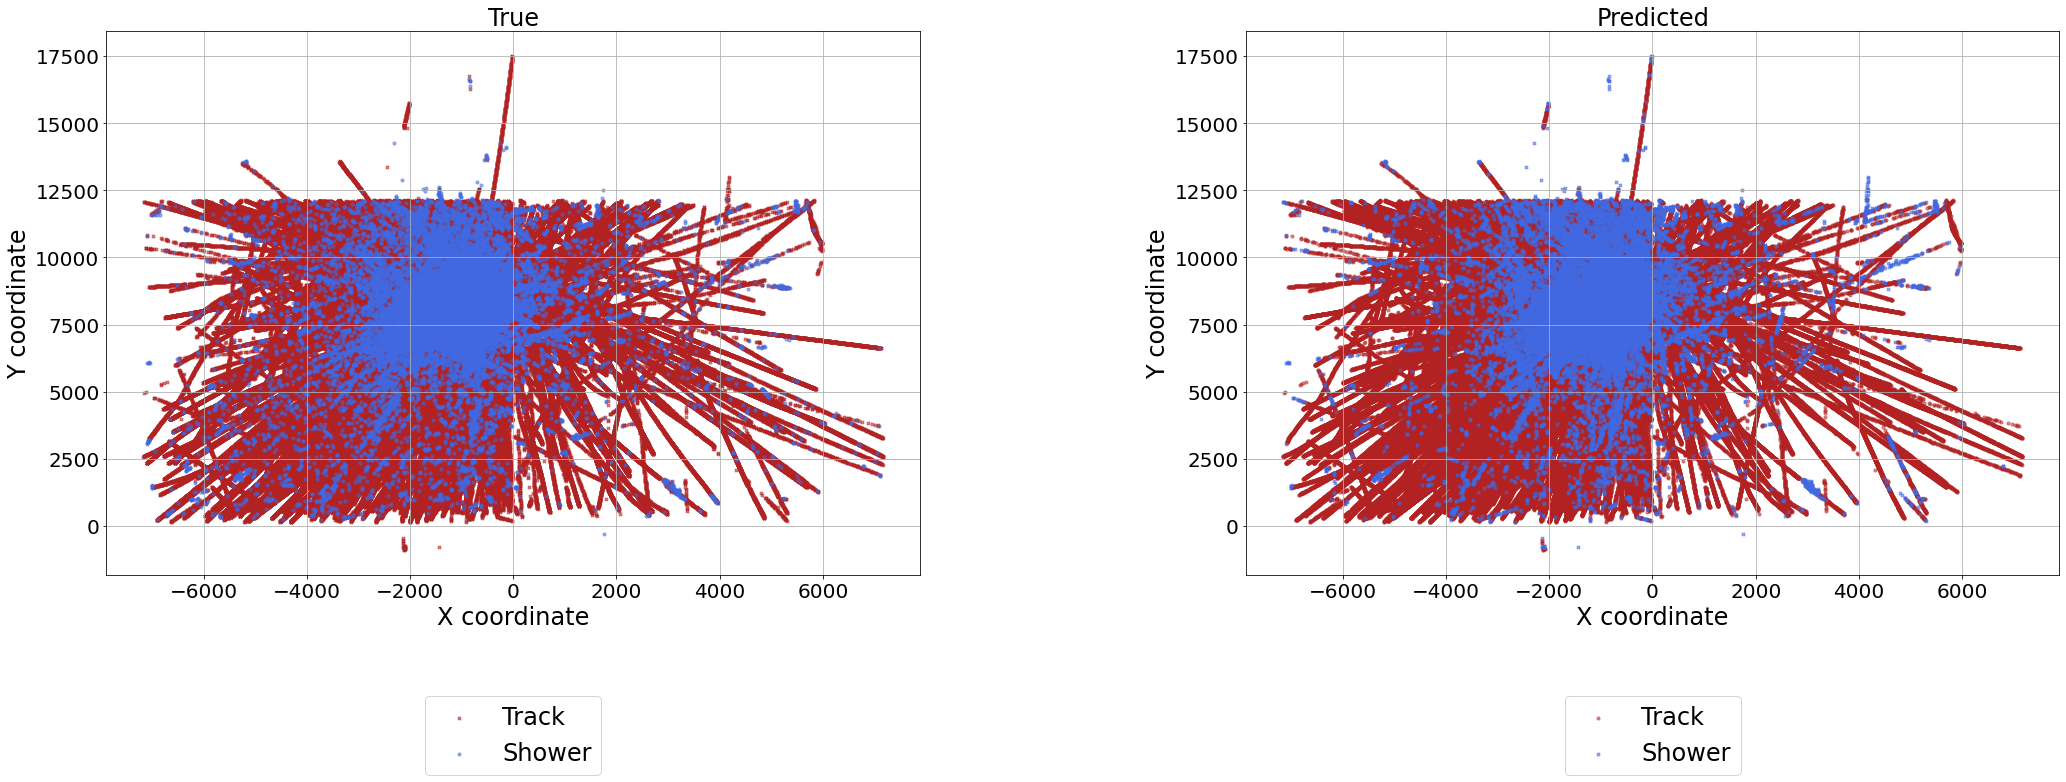

In [22]:
## Plotting X and Y

fig = plt.figure(figsize=(35,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


ax = fig.add_subplot(1, 2, 1)


plt.scatter(data_track_x_true, data_track_y_true, color='firebrick', label="Track", marker="X", s=10, alpha=0.5)
plt.scatter(data_shower_x_true, data_shower_y_true, color='royalblue', label="Shower", marker="o", s=10, alpha=0.5)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
plt.title("True")
plt.xlabel("X coordinate")
plt.ylabel('Y coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom



ax = fig.add_subplot(1, 2, 2)
plt.scatter(data_track_x_pred, data_track_y_pred, color='firebrick', label="Track", marker="o", s=10, alpha=0.5)
plt.scatter(data_shower_x_pred, data_shower_y_pred, color='royalblue', label="Shower", marker="X", s=10, alpha=0.5)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
plt.title("Predicted")
plt.xlabel("X coordinate")
plt.ylabel('Y coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom

plt.savefig("plot_2d_X_Y_both.png")



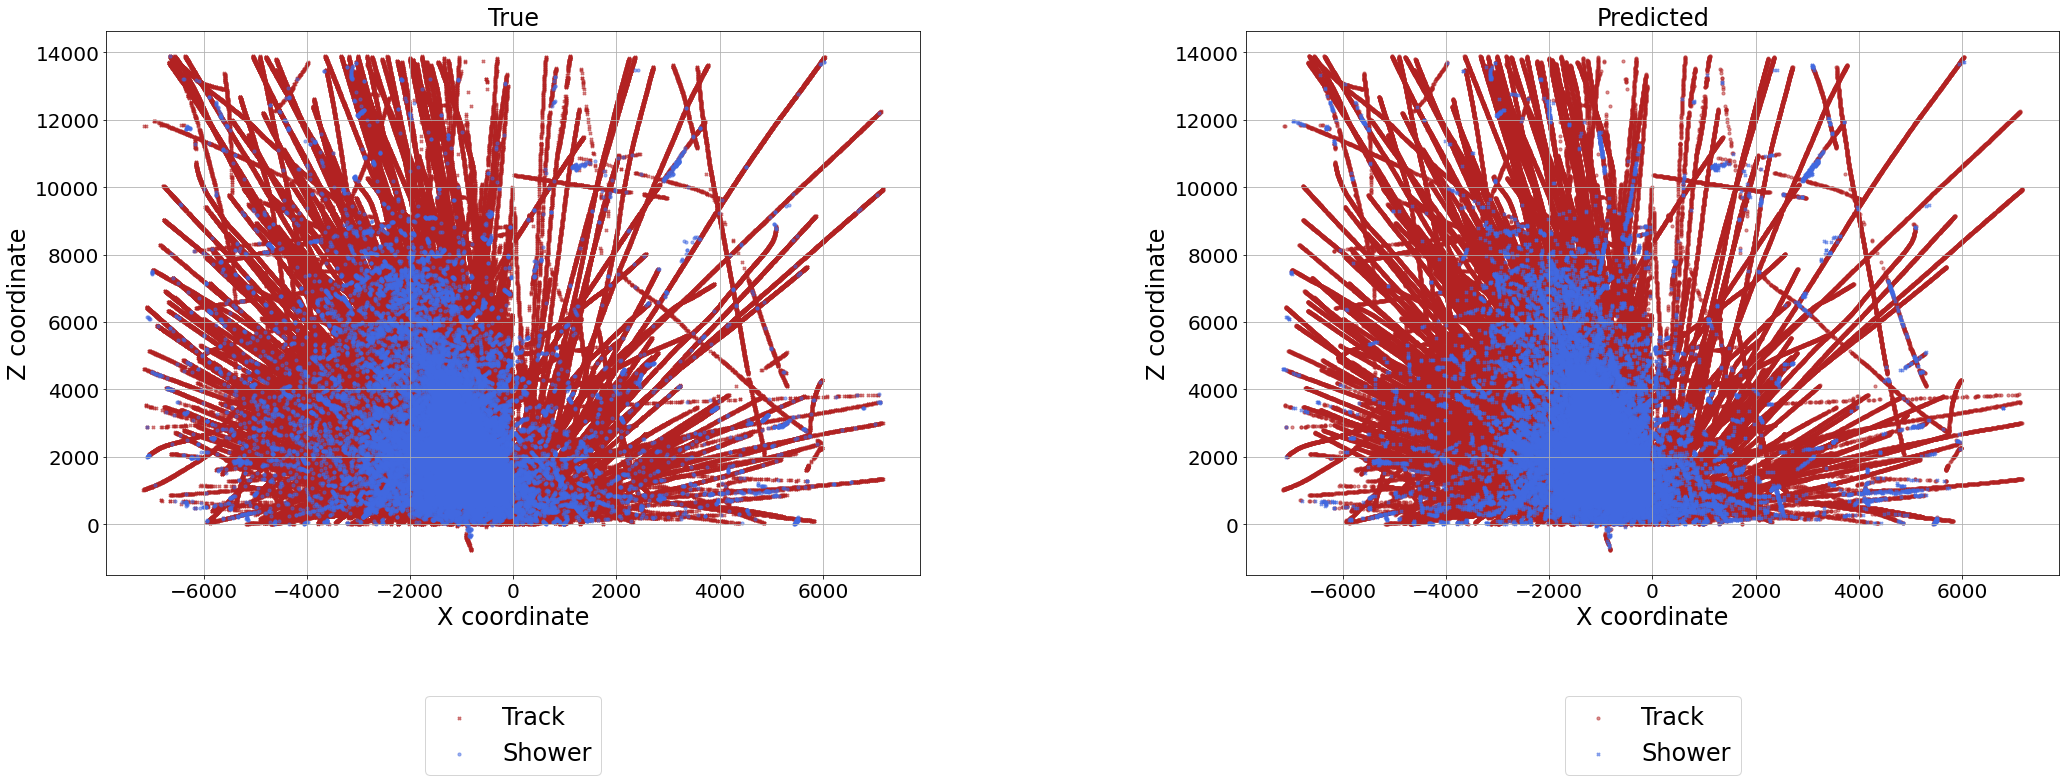

In [23]:
## Plotting X and Z

fig = plt.figure(figsize=(35,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


ax = fig.add_subplot(1, 2, 1)


plt.scatter(data_track_x_true, data_track_z_true, color='firebrick', label="Track", marker="X", s=10, alpha=0.5)
plt.scatter(data_shower_x_true, data_shower_z_true, color='royalblue', label="Shower", marker="o", s=10, alpha=0.5)


ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
plt.title("True")
plt.xlabel("X coordinate")
plt.ylabel('Z coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom



ax = fig.add_subplot(1, 2, 2)
plt.scatter(data_track_x_pred, data_track_z_pred, color='firebrick', label="Track", marker="o", s=10, alpha=0.5)
plt.scatter(data_shower_x_pred, data_shower_z_pred, color='royalblue', label="Shower", marker="X", s=10, alpha=0.5)

ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
plt.title("Predicted")
plt.xlabel("X coordinate")
plt.ylabel('Z coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom

plt.savefig("plot_2d_X_Z_both.png")



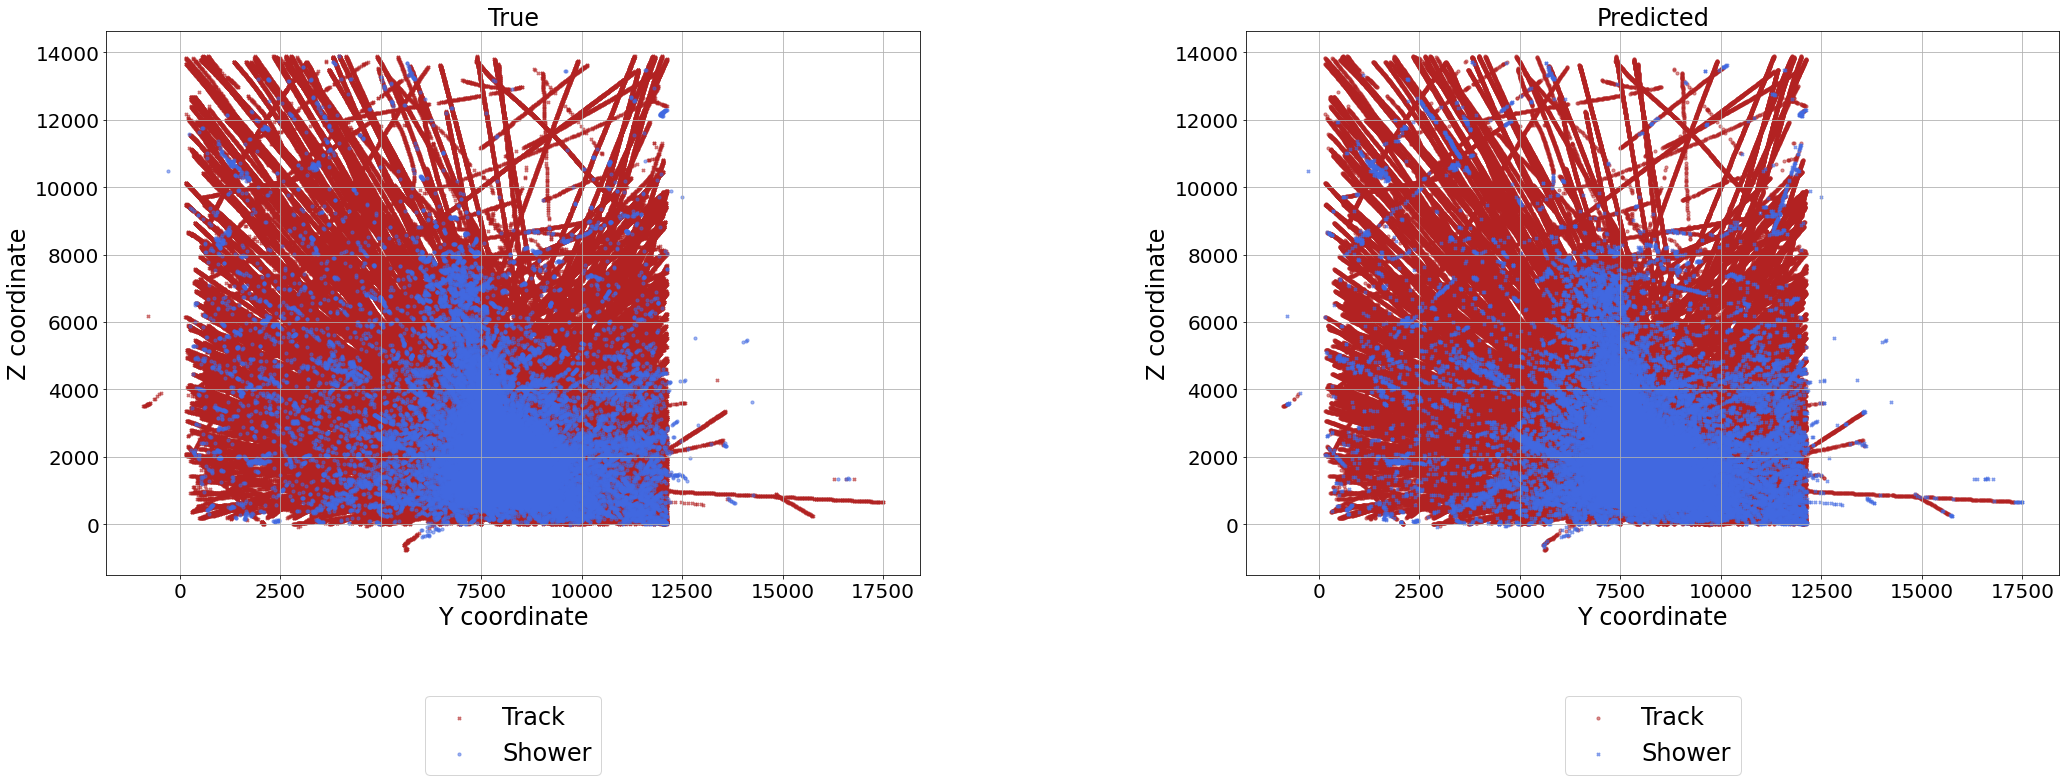

In [24]:
## Plotting Y and Z

fig = plt.figure(figsize=(35,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


ax = fig.add_subplot(1, 2, 1)


plt.scatter(data_track_y_true, data_track_z_true, color='firebrick', label="Track", marker="X", s=10, alpha=0.5)
plt.scatter(data_shower_y_true, data_shower_z_true, color='royalblue', label="Shower", marker="o", s=10, alpha=0.5)


ax.set_xlabel('Y Label')
ax.set_ylabel('Z Label')
plt.title("True")
plt.xlabel("Y coordinate")
plt.ylabel('Z coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom



ax = fig.add_subplot(1, 2, 2)
plt.scatter(data_track_y_pred, data_track_z_pred, color='firebrick', label="Track", marker="o", s=10, alpha=0.5)
plt.scatter(data_shower_y_pred, data_shower_z_pred, color='royalblue', label="Shower", marker="X", s=10, alpha=0.5)

ax.set_xlabel('Y Label')
ax.set_ylabel('Z Label')
plt.title("Predicted")
plt.xlabel("Y coordinate")
plt.ylabel('Z coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom


plt.savefig("plot_2d_Y_Z_both.png")